<a href="https://colab.research.google.com/github/jmhuer/shift_invariant_dictionary_learning/blob/main/HTwAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pretty_midi
!git clone https://github.com/jmhuer/ModularSparseAutoencoder
!git clone https://github.com/music-x-lab/POP909-Dataset
!git clone https://github.com/jmhuer/HT
!git clone https://github.com/Tsung-Ping/functional-harmony
# %cd /content/POP909-Dataset/data_process
!pip install libfmp

     |████████████████████████████████| 5.6 MB 15.2 MB/s 
     |████████████████████████████████| 51 kB 8.0 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591953 sha256=28d7ebfd4f0ed79a526de449f720b33380b8a010abb3a54bfd6e8917363b803c
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi
Cloning into 'ModularSparseAutoencoder'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 28 (delta 12), reused 10 (delta 2), pack-reused 0
Unpacking objects: 100% (28/28), done.
Cloning into 'POP909-Dataset'...
remote: Enumerating objects: 9265, done.
remote: Counting objects: 100% (9265/9265), done.
remote: Compressing objects: 100% (8157/8157), done.
remote: Total 9265 (delta 13), reused 9245 (delta 6), pack-reused 0
Receiving objects: 100% (9265/9265), 45.75 MiB | 18.58 MiB/s,

In [2]:
from HT.BPS_FH_preprocessing import main

main()

Message: load note data ...
lowest pitch = 24 highest pitch =  101
Message: load chord labels...
Message: get framewise labels ...
max_length = 8482
min_length = 872
keys in corpus['op'] = dict_keys(['pianoroll', 'chromagram', 'start_time', 'label'])
label fields =  [('op', '<U10'), ('onset', '<f8'), ('key', '<U10'), ('degree1', '<U10'), ('degree2', '<U10'), ('quality', '<U10'), ('inversion', '<i8'), ('rchord', '<U10'), ('root', '<U10'), ('tquality', '<U10'), ('chord_change', '<i8')]
Running Message: augment data...
keys in corpus_aug['shift_id']['op'] = dict_keys(['pianoroll', 'tonal_centroid', 'start_time', 'label'])
Running Message: reshape data...
keys in corpus_aug_reshape['shift_id']['op'] = dict_keys(['pianoroll', 'tonal_centroid', 'start_time', 'label', 'len'])
sequence_len_non_overlaped = [17, 22, 23, 24, 30, 34, 36, 40, 44, 48, 52, 53, 66, 72, 80, 84, 86, 88, 100, 102, 104, 116, 118, 120, 128]
sequence_len_overlaped = [17, 22, 23, 24, 30, 34, 36, 40, 44, 48, 52, 53, 66, 72, 8

In [3]:
# !pip install tensorflow-gpu==1.15
from HT.chord_symbol_recognition import train_HT
from collections import Counter, namedtuple
from HT.BPS_FH_preprocessing import main
from HT.chord_symbol_recognition import load_data_symbol
#

import pickle
import os
import sys
# import utils
import pretty_midi 
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch


##only tensor transforms


datasetpath = '/content/'

train_data, test_data = load_data_symbol(dir=datasetpath + 'BPS_FH_preprocessed_data_MIREX_Mm.pickle', test_set_id=1, sequence_with_overlap=True)
print("load_data_symbol train_data size: {}".format(train_data["tchord"].shape))



# dataset = load_data(train_data, test_data, batch_size=16)



Instructions for updating:
non-resource variables are not supported in the long term
Load chord symbol data...
test_set_id = 1
keys in corpus_aug_reshape['shift_id']['op'] = dict_keys(['pianoroll', 'tonal_centroid', 'start_time', 'label', 'len'])
shift_list = ['shift_-1', 'shift_-2', 'shift_-3', 'shift_0', 'shift_1', 'shift_2', 'shift_3', 'shift_4', 'shift_5', 'shift_6']
train_op_list = ['2', '3', '4', '6', '7', '8', '10', '11', '12', '14', '15', '16', '18', '19', '20', '22', '23', '24', '26', '27', '28', '30', '31', '32']
test_op_list = ['1', '5', '9', '13', '17', '21', '25', '29']
train_data:  [('pianoroll', (54320, 128, 88)), ('tonal_centroid', (54320, 128, 6)), ('len', (54320,)), ('label', (54320, 128)), ('root', (54320, 128)), ('tquality', (54320, 128)), ('tchord', (54320, 128))]
test_data:  [('pianoroll', (294, 128, 88)), ('tonal_centroid', (294, 128, 6)), ('len', (294,)), ('label', (294, 128)), ('root', (294, 128)), ('tquality', (294, 128)), ('tchord', (294, 128))]
label fields:

In [283]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import random

class autoencoder:
    def __init__(self):
        self.weights = {
            'encoder_h1': tf.Variable(tf.random_normal([88, 20])/100),
            'encoder_h2': tf.Variable(tf.random_normal([4000, 1000])/100),
            'decoder_h1': tf.Variable(tf.random_normal([1000, 2000])/100),
            'decoder_h2': tf.Variable(tf.random_normal([20, 88])/100)
        }
        self.biases = {
            'encoder_b1': tf.Variable(tf.random_normal([1000])),
            'decoder_b1': tf.Variable(tf.random_normal([11264]))
        }
        # Building the encoder
    def encoder(self, x):
        # Encoder Hidden layer with sigmoid activation #1
        layer_1 = tf.nn.relu(tf.matmul(x, self.weights['encoder_h1']))
        return layer_1
    # Building the decoder
    def decoder(self, x):
        layer_2 = tf.nn.relu(tf.matmul(x, self.weights['decoder_h2']))
        return layer_2
    def code(self, x):
        # do =  x[0,:,:]
        # x = tf.layers.flatten(x)
        encoder_op = self.encoder(x)
        decoder_op = self.decoder(encoder_op)
        # x = tf.zeros((40, 128,88))
        # decoder_op = tf.placeholder_with_default(decoder_op,[None, 128, 88])

        # # print("decoder x shape ",x.shape)
        # # self.save(tf.transpose(tf.identity(x)[0,:,:]))
        # print("xshape", x.shape)
        # x_p = tf.placeholder(tf.int32, [None, hp.n_steps, 88], name="pianoroll")
        # tf.assign(x_p,decoder_op)
        # # with tf.Session() as sess:
        # #     o = sess.run(x_p.assign(decoder_op)) # == 5.0, using the Tensor value
        #     print("o shape", o)
        #     # sess.run(x_p, {feed_dict={x_p: o.astype(int)})
        return x



# zeros = tf.zeros((1,128,88))
# ae = autoencoder()
# ae.code(zeros)
# ae.reload()




# This preprocesses data and creates pickle


In [284]:
from HT.chord_symbol_recognition import train_HT
from collections import Counter, namedtuple


# Chord symbol recognition
# train_BTC() # Bi-directional Transformer for Chord Recognition
# train_CRNN() # Convolutional Recurrent Neural Network
root_dict = {'C': 0, 'C+': 1, 'D': 2, 'D+': 3, 'E': 4, 'F': 5, 'F+': 6, 'G': 7, 'G+': 8, 'A': 9, 'A+': 10, 'B': 11, 'pad': 12}
tquality_dict = {'M': 0, 'm': 1, 'O': 2, 'pad': 3}  # 'O' stands for 'others'
n_chord_classes = 24 + 1  # 24 major-minor modes plus 1 others

ae = autoencoder()
# Hyperparameters
hyperparameters = namedtuple('hyperparameters',
                              ['dataset',
                              'test_set_id',
                              'graph_location',
                              'n_root_classes',
                              'n_tquality_classes',
                              'n_chord_classes',
                              'n_steps',
                              'input_embed_size',
                              'n_layers',
                              'n_heads',
                              'train_sequence_with_overlap',
                              'initial_learning_rate',
                              'drop',
                              'n_batches',
                              'n_training_steps',
                              'n_in_succession',
                              'annealing_rate',
                               'autoencoder'])

hp = hyperparameters(dataset='/content/', # {'BPS_FH', 'Preludes'}
                      test_set_id=1, # {1, 2, 3, 4}
                      graph_location='model',
                      n_root_classes=len(root_dict.keys()),
                      n_tquality_classes=len(tquality_dict.keys()),
                      n_chord_classes=n_chord_classes,
                      n_steps=128,
                      input_embed_size=128,
                      n_layers=2,
                      n_heads=4,
                      train_sequence_with_overlap=True,
                      initial_learning_rate=1e-4,
                      drop=0.1,
                      n_batches=40,
                      n_training_steps=100000,
                      n_in_succession=10,
                      annealing_rate=1.1,
                      autoencoder=ae)

# Make pytorch dataloader

In [285]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [286]:
train_HT(hp, train_data, test_data2)


Saving graph to: model
Train the model...
()
*~ loss_cc 0.9416, loss_tc 4.2372 ~*, loss_ae 0.0127 ~*
*~ loss_cc 0.3288, loss_tc 1.4117 ~*, loss_ae 0.0155 ~*
enc_w = [0.3308837  0.34862277 0.32049352] dec_w = [0.32207668 0.34048346 0.3374399 ]
len = 128
y_root    G  G  G  G  G  G  G  G  G  G  G  G  G  G  G  G  G  G  G  G  G  G  G  G  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  G  G  G  G  G  G  G  G  C  C  C  C  C  C  C  C
y_tq      M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M  M
valid     y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y  y
y_cc      0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

KeyboardInterrupt: ignored

In [ ]:
# train_data2 = {}
test_data2 = {}
# train_data2['label'] = {}
test_data2['label'] = {}

# train_data2['label']['chord_change']= train_data['label']['chord_change'][0:54096]
# train_data2["pianoroll"] =  train_data['pianoroll'][0:54096]
# train_data2["tchord"] =  train_data['tchord'][0:54096]
# train_data2["root"] =  train_data['root'][0:54096]
# train_data2["len"] =  train_data['len'][0:54096]
# train_data2["tquality"] =  train_data['tquality'][0:54096]
n = 40  # for 2 random indices
index = np.random.choice(test_data["tchord"].shape[0], n, replace=False)
            
test_data2['label']['chord_change'] =  test_data['label']['chord_change'][index]
test_data2["pianoroll"] =  test_data['pianoroll'][index]
test_data2["tchord"] =  test_data['tchord'][index]
test_data2["root"] =  test_data['root'][index]
test_data2["len"] =  test_data['len'][index]
test_data2["tquality"] = test_data['tquality'][index]


#test

#play example from BPS dataset

In [297]:


def piano_roll_to_pretty_midi(piano_roll, fs=8, program=0):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm




In [298]:
import IPython.display
index = 54 ## 44 66 & 0 & 1 500 omg 1021

#lets play a batch 
pianoex = test_data["pianoroll"]
# for i,ba in enumerate(pianoex): 
#     ##print(ba[0].shape)
#     if i < index: 
#         continue
#     listen = i


def pad88to128(piano_roll):
    arr = np.zeros((128,int(piano_roll.shape[1])))
    pad = (128 - 88)//2
    arr[pad:(128-pad),0:arr.shape[1]] = piano_roll
    return arr

print(pianoex[index].T.shape)
arr = pad88to128(pianoex[index].T)
pm = piano_roll_to_pretty_midi(arr)
IPython.display.Audio(pm.synthesize(fs=16000), rate=16000)


(88, 128)


(<Figure size 576x216 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc21fb52710>)

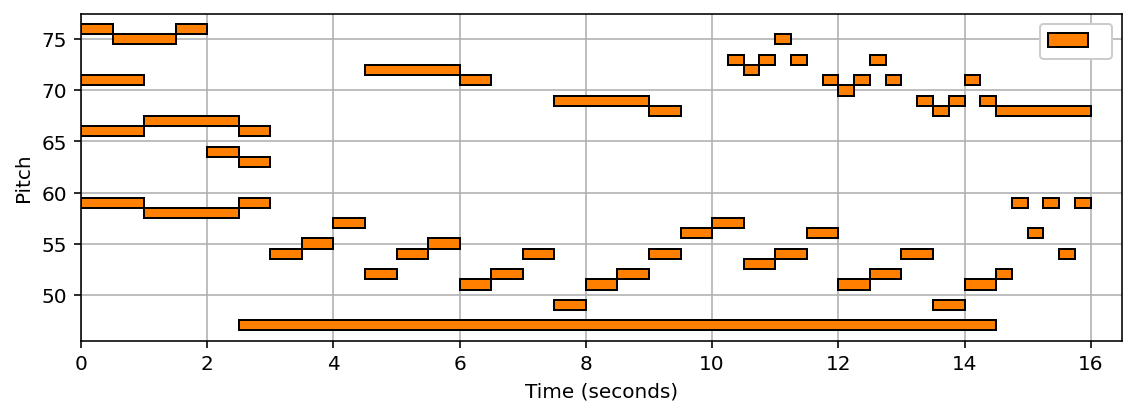

In [299]:
import libfmp.c1
score = libfmp.c1.midi_to_list(pm)

libfmp.c1.visualize_piano_roll(score, figsize=(8, 3))


In [300]:
import IPython.display
index = 54 ## 44 66 & 0 & 1 500 omg 1021
import tensorflow.compat.v1 as tf

#lets play a batch 
pianoex = train_data["pianoroll"]

def pad88to128(piano_roll):
    arr = np.zeros((128,int(piano_roll.shape[1])))
    pad = (128 - 88)//2
    arr[pad:(128-pad),0:arr.shape[1]] = piano_roll
    return arr

m = np.array(pianoex[index].astype("float32"))
print(m.shape)
model_checkpoint = '/content/mmymymymy-0'

g = tf.train.import_meta_graph('/content/mmymymymy-0.meta')
print(g)

init = tf.compat.v1.global_variables_initializer()
with tf.compat.v1.Session() as sess: 
    init.run() 
    g.restore(sess, model_checkpoint)
    out =s hp.autoencoder.code(m)
    s = 0.5* tf.reduce_mean(tf.pow(out - m, 2))
    np_out = sess.run(out)
    ss = sess.run(s)

print("MSE: ", ss)

np_out = np_out.T

arr = pad88to128(np_out)
pm = piano_roll_to_pretty_midi(arr)
IPython.display.Audio(pm.synthesize(fs=16000), rate=16000)


(128, 88)
INFO:tensorflow:Restoring parameters from /content/mmymymymy-0


TypeError: ignored

(<Figure size 576x216 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc20b9cac50>)

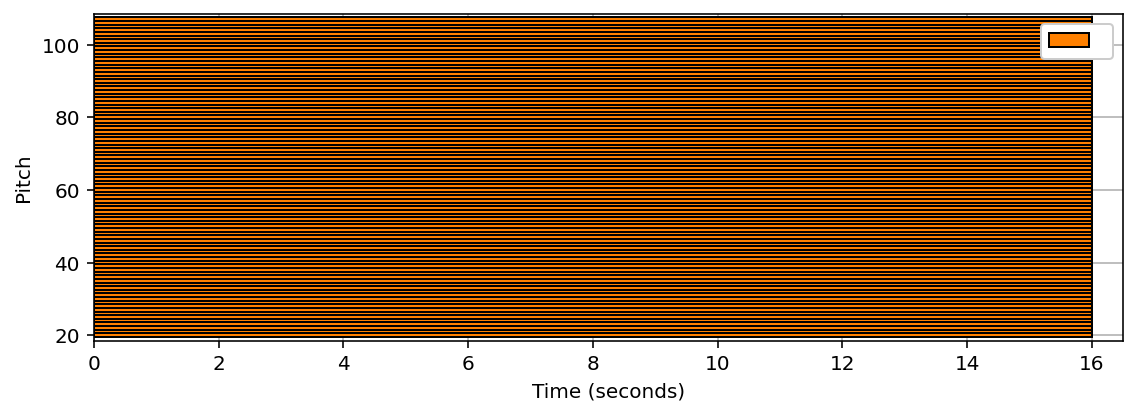

In [282]:
import libfmp.c1
score = libfmp.c1.midi_to_list(pm)

libfmp.c1.visualize_piano_roll(score, figsize=(8, 3))
